<a href="https://colab.research.google.com/github/Asma-Draouil/Feature_Asma/blob/main/Vectorisation_licence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Data Preprocessing

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk


In [2]:
df = pd.read_csv('licence/licence.csv')


In [3]:
data_cleaned = df.copy()

In [4]:
parcours = [
    "Comptabilité",
    "Management",
    "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision",
    "Business Intelligence",
    "Business Information Systems"
]
data_cleaned.insert(0, "Parcours", parcours[:len(data_cleaned)])


In [5]:
# Télécharger les ressources nécessaires pour NLTK
nltk.download('stopwords')


# Charger les stopwords en français
stop_words = set(stopwords.words('french'))

def nettoyer_colonne_avance(texte):
    if not isinstance(texte, str):  # Vérifie que la valeur est une chaîne
        return ''
    # Convertir en minuscules
    texte = texte.lower()
    # Remplacer les caractères spéciaux et ponctuations par des espaces
    texte = re.sub(r'[^\w\s]', ' ', texte)
    # Supprimer les espaces multiples
    texte = re.sub(r'\s+', ' ', texte).strip()
    # Supprimer les mots inutiles
    mots = texte.split()  # Divise le texte en mots avec split (pas de tokenisation)
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots)  # Recombine les mots filtrés


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Liste des colonnes textuelles
colonnes_textuelles = [
    "Objectifs", "Contenu", "Compétences", "Métiers",
    "Secteurs d’activité", "Partenariats professionnels",
    "Semestre 1", "Semestre 2", "Semestre 3", "Semestre 4", "Semestre 5", "Semestre 6"
]

# Vérifiez quelles colonnes existent dans le DataFrame
colonnes_existe = [col for col in colonnes_textuelles if col in data_cleaned.columns]


for col in colonnes_existe:
    data_cleaned[col] = data_cleaned[col].fillna('').apply(nettoyer_colonne_avance)



In [7]:
data_cleaned = data_cleaned.fillna('')

In [9]:
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

# Appliquer la tokenisation à chaque cellule de toutes les colonnes
data_cleaned = data_cleaned.apply(lambda col: col.apply(word_tokenize))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
from nltk.stem.snowball import FrenchStemmer

# Initialiser le stemmer pour le français
stemmer = FrenchStemmer()

# Exemple d'application du stemming sur des données tokenisées
data_cleaned = data_cleaned.applymap(
    lambda x: [stemmer.stem(word) for word in x] if isinstance(x, list) else x
)


<ipython-input-10-f4411294fbbd>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_cleaned = data_cleaned.applymap(


In [12]:
#Vectorisation avec tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
# Remplacer les valeurs manquantes par une chaîne vide et convertir toutes les colonnes en chaînes
data_cleaned = data_cleaned.fillna('').astype(str)

# Exclure la colonne 'Parcours'
colonnes_a_vectoriser = data_cleaned.drop(columns=['Parcours']).columns

# Vectorisation avec gestion des erreurs de type
vecteurs = {}
tfidf_vectorizer = TfidfVectorizer(max_features=500)

for col in colonnes_a_vectoriser:
    vecteurs[col] = tfidf_vectorizer.fit_transform(data_cleaned[col])

# Combiner les matrices TF-IDF
from scipy.sparse import hstack
vecteurs_combines = hstack(list(vecteurs.values()))
# Afficher la dimension de la matrice finale
print(f"Dimensions de la matrice combinée : {vecteurs_combines.shape}")



Dimensions de la matrice combinée : (5, 812)


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


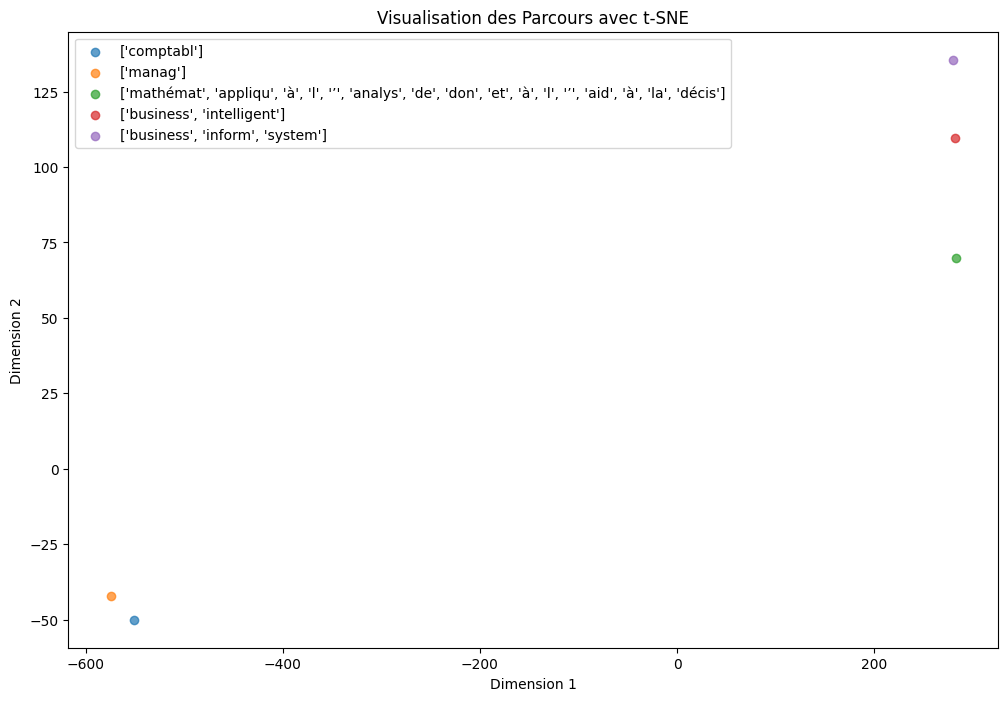

In [13]:
# Visualisation avec t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=1, n_iter=1000)
data_tsne = tsne.fit_transform(vecteurs_combines.toarray())

# Créer un DataFrame pour visualisation
import matplotlib.pyplot as plt
df_tsne = pd.DataFrame(data_tsne, columns=['Dimension 1', 'Dimension 2'])
df_tsne['Parcours'] = data_cleaned['Parcours']

# Visualisation
plt.figure(figsize=(12, 8))
for parcours in df_tsne['Parcours'].unique():
    subset = df_tsne[df_tsne['Parcours'] == parcours]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=parcours, alpha=0.7)

plt.title("Visualisation des Parcours avec t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()


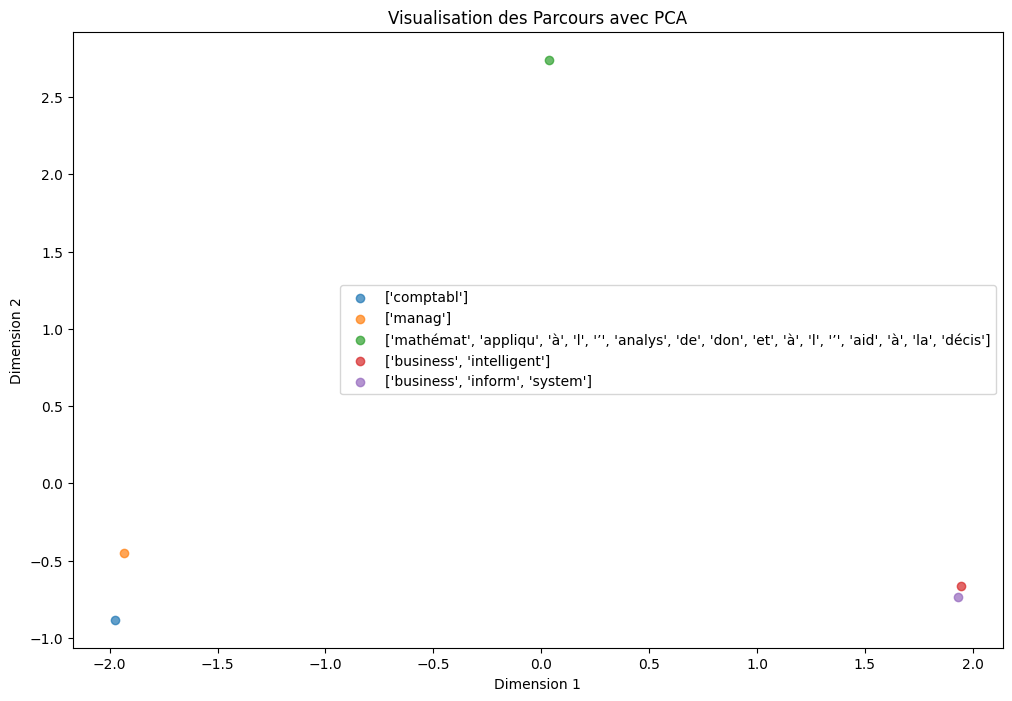

In [14]:
# Visualisation avec PCA (Réduction dimensionnelle )
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(vecteurs_combines.toarray())

# Créer un DataFrame pour visualisation
df_pca = pd.DataFrame(data_pca, columns=['Dimension 1', 'Dimension 2'])
df_pca['Parcours'] = data_cleaned['Parcours']

# Visualisation
plt.figure(figsize=(12, 8))
for parcours in df_pca['Parcours'].unique():
    subset = df_pca[df_pca['Parcours'] == parcours]
    plt.scatter(subset['Dimension 1'], subset['Dimension 2'], label=parcours, alpha=0.7)

plt.title("Visualisation des Parcours avec PCA")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [ ]:
# Vectorisation avec words embedding

import gensim.downloader as api
import numpy as np

# Charger le modèle Word2Vec pré-entraîné
word2vec_model = api.load("word2vec-google-news-300")

# Remplacer les valeurs manquantes par une chaîne vide et convertir toutes les colonnes en chaînes
data_cleaned = data_cleaned.fillna('').astype(str)

# Sélectionner toutes les colonnes à vectoriser
colonnes_a_vectoriser = data_cleaned.columns

# Fonction pour vectoriser un texte avec Word2Vec
def vectorize_text(text, model):
    words = text.split()  # Diviser le texte en mots
    vectors = []

    for word in words:
        if word in model:  # Si le mot existe dans le vocabulaire du modèle
            vectors.append(model[word])
        else:
            vectors.append(np.zeros(300))  # Vecteur nul pour les mots inconnus

    # Moyenne des vecteurs de mots pour obtenir un seul vecteur
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)  # Retourner un vecteur nul si le texte est vide

# Vectoriser chaque colonne et convertir en matrice 2D
vecteurs = {}
for col in colonnes_a_vectoriser:
    vecteurs[col] = np.array([vectorize_text(str(text), word2vec_model) for text in data_cleaned[col]])

# Convertir chaque tableau 2D pour compatibilité avec hstack
matrices = [np.array(vecteurs[col]) for col in colonnes_a_vectoriser]

# Combiner les matrices horizontalement
vecteurs_combines_embedding = np.hstack(matrices)

# Afficher les dimensions de la matrice finale
print(f"Dimensions de la matrice combinée : {vecteurs_combines_embedding.shape}")

[===========================-----------------------] 54.2% 900.4/1662.8MB downloaded

In [ ]:
# Visualisation avec t-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduction de dimensions avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=4, n_iter=1000)
vecteurs_tsne = tsne.fit_transform(vecteurs_combines_embedding)

# Visualisation avec t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(vecteurs_tsne[:, 0], vecteurs_tsne[:, 1], alpha=0.7, s=20, c='green')
plt.title("Visualisation des données avec t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
# Visualisation avec PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Réduction de dimensions avec PCA
pca = PCA(n_components=2)  # Réduire à 2 dimensions
vecteurs_pca = pca.fit_transform(vecteurs_combines_embedding)

# Visualisation avec PCA
plt.figure(figsize=(8, 6))
plt.scatter(vecteurs_pca[:, 0], vecteurs_pca[:, 1], alpha=0.7, s=20, c='blue')
plt.title("Visualisation des données avec PCA")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


NameError: name 'vecteurs_combines_embedding' is not defined

### Model Training 

#### Simularity Computation 